# W6_Exploring Precision and Recall

In [1]:
import numpy as np
import pandas as pd
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('amazon_baby.csv')
data = data.fillna(value={'review':''}) # replace all NaN elements in column ‘review’ with ''
data = data.fillna(value={'name':''}) 

# perform text cleaning
def remove_punctuation(text):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    return text.translate(table)

data['cleaned_review'] = data['review'].apply(remove_punctuation)
data.head()

,name,review,rating,cleaned_review
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,These flannel wipes are OK but in my opinion n...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...


In [3]:
# extract sentiments
data = data[data['rating'] != 3]
data['sentiment'] = data['rating'].apply(lambda rating : +1 if rating > 3 else -1) # 1 means positive; -1 means negative
data.head()

,name,review,rating,cleaned_review,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


In [4]:
train_index = list(pd.read_json('module-9-assignment-train-idx.json')[0])
test_index = list(pd.read_json('module-9-assignment-test-idx.json')[0])

train = data.iloc[train_index]
test = data.iloc[test_index]

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['cleaned_review'])
test_matrix = vectorizer.transform(test['cleaned_review'])

In [5]:
model = LogisticRegression().fit(X=train_matrix, y=train['sentiment'])

In [6]:
# accurancy
model.score(test_matrix, test['sentiment'])

0.93229541636669067

In [7]:
# baseline: majority class prediction
(train['sentiment']==1).sum() > (train['sentiment']==-1).sum()

True

In [8]:
(test['sentiment']==1).sum() / len(test)

0.84278257739380846

In [9]:
# confusion matrix
c_mat = confusion_matrix(y_true=test['sentiment'], y_pred=model.predict(test_matrix), labels=model.classes_)
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{:^13} | {:^15} | {:5d}'.format(target_label, predicted_label, c_mat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   804
      1       |        1        | 27291


In [10]:
# compute the cost of mistakes
100*c_mat[0][1] + 1*c_mat[1][0]

146104

In [11]:
# precision
precision = precision_score(y_true=test['sentiment'], y_pred=model.predict(test_matrix))
print('# Precision on test data: %s' % precision)

# Precision on test data: 0.949450320067


In [12]:
1-precision

0.050549679933203473

In [13]:
# recall
recall = recall_score(y_true=test['sentiment'], y_pred=model.predict(test_matrix))
print('# Recall on test data: %s' % recall)

# Recall on test data: 0.971382808329


In [14]:
# varying the threshold
def apply_threshold(probabilities, threshold):
    v_fun = np.vectorize(lambda x: 1 if x>threshold else -1)
    predictions = v_fun(probabilities)
    return predictions

prob = model.predict_proba(test_matrix)[:,1]
predictions_05 = apply_threshold(prob, 0.5)
predictions_09 = apply_threshold(prob, 0.9)

print('# of predicted label = 1')
print('threshold=0.5:',(predictions_05==1).sum())
print('threshold=0.9:',(predictions_09==1).sum())

# of predicted label = 1
threshold=0.5: 28744
threshold=0.9: 25070


In [15]:
# explore the associated precision and recall as the threshold varies
print('# precision')
print('threshold=0.5:', precision_score(y_true=test['sentiment'], y_pred=predictions_05))
print('threshold=0.9:', precision_score(y_true=test['sentiment'], y_pred=predictions_09))
print('--------------------')
print('# recall')
print('threshold=0.5:', recall_score(y_true=test['sentiment'], y_pred=predictions_05))
print('threshold=0.9:', recall_score(y_true=test['sentiment'], y_pred=predictions_09))

# precision
threshold=0.5: 0.949450320067
threshold=0.9: 0.981491822896
--------------------
# recall
threshold=0.5: 0.971382808329
threshold=0.9: 0.875814201815


In [16]:
threshold_values = np.linspace(0.5, 1, num=100)
threshold_values = threshold_values[:99] # remove threshold = 1
print(threshold_values)

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [17]:
precision_list = []
recall_list = []
for threshold in threshold_values:
    predictions = apply_threshold(prob, threshold)
    precision_list.append(precision_score(y_true=test['sentiment'], y_pred=predictions))
    recall_list.append(recall_score(y_true=test['sentiment'], y_pred=predictions))

In [18]:
def plot_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

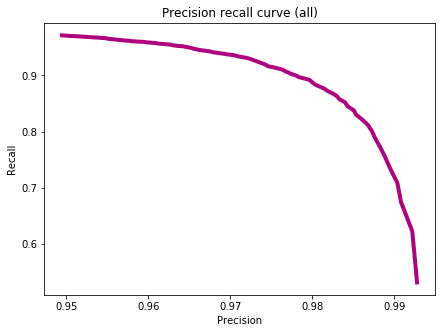

In [19]:
plot_curve(precision_list, recall_list, 'Precision recall curve (all)')

In [20]:
for (threshold, precision) in zip(threshold_values, precision_list):
    if precision >= 0.965:
        print(threshold, precision)
        break

0.707070707071 0.965116699837


In [21]:
predictions_098 = apply_threshold(prob, 0.98)
c_mat_098 = confusion_matrix(y_true=test['sentiment'], y_pred=predictions_098, labels=model.classes_)
c_mat_098

array([[ 5047,   194],
       [ 8210, 19885]])

In [22]:
# precision-recall on all baby related items
baby_reviews = test[test['name'].apply(lambda x: 'baby' in x.lower())]
baby_matrix = vectorizer.transform(baby_reviews['cleaned_review'])
baby_prob = model.predict_proba(baby_matrix)

precision_list = []
recall_list = []
for threshold in threshold_values:
    predictions = apply_threshold(baby_prob, threshold)[:,1]
    precision_list.append(precision_score(y_true=baby_reviews['sentiment'], y_pred=predictions))
    recall_list.append(recall_score(y_true=baby_reviews['sentiment'], y_pred=predictions))

for (threshold, precision) in zip(threshold_values, precision_list):
    if precision >= 0.965:
        print(threshold, precision)
        break

0.737373737374 0.966466841514


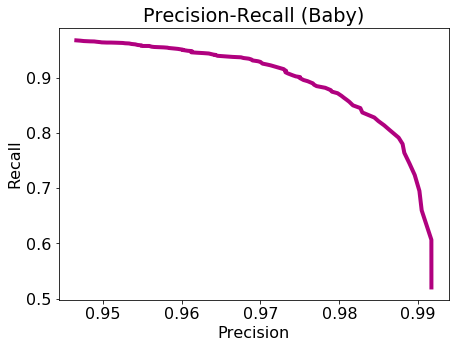

In [23]:
plot_curve(precision_list, recall_list, "Precision-Recall (Baby)")